# import 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import sys
import time
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import xgboost as xgb
import lightgbm as lgb
# import catboost as cat

from tqdm import tqdm_notebook
from multiprocessing import cpu_count
from scipy.stats import norm, entropy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [2]:
pd.options.display.max_columns = None

In [3]:
PATH = os.path.join('..', 'input')

 # read

In [4]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

# feature selection

In [32]:
train.shape, test.shape

((200000, 202), (200000, 201))

In [29]:
for c in train.columns[2:]:
    print(c, len(train[c].unique()), len(train.query('target == 0')[c].unique()), len(train.query('target == 1')[c].unique()))

var_0 94672 89960 18473
var_1 108932 102890 18744
var_2 86555 82724 18153
var_3 74597 72076 17678
var_4 63515 61723 17103
var_5 141029 130834 19334
var_6 38599 37789 15177
var_7 103063 97968 18565
var_8 98617 93955 18495
var_9 49417 48296 16300
var_10 128764 120493 19133
var_11 130193 121666 19181
var_12 9561 9507 7312
var_13 115181 108439 18923
var_14 79122 76420 17782
var_15 19810 19620 11437
var_16 86918 83282 18078
var_17 137823 128279 19283
var_18 139515 129724 19332
var_19 144180 133653 19398
var_20 127764 119578 19082
var_21 140062 130038 19337
var_22 90660 86374 18299
var_23 24913 24607 12753
var_24 105101 99675 18694
var_25 14853 14709 9430
var_26 127089 118571 19160
var_27 60185 58670 16926
var_28 35859 35201 14725
var_29 88339 84606 18084
var_30 145977 135286 19426
var_31 77388 74590 17629
var_32 85964 82542 18094
var_33 112239 105967 18858
var_34 25164 24790 12997
var_35 122384 114829 18985
var_36 96404 91806 18424
var_37 79040 76201 17805
var_38 115366 108839 18923
var_39 

In [33]:
train['var_68'].unique()

array([5.0109, 5.022 , 5.0228, 5.0301, 5.011 , 5.0178, 5.0128, 5.0157,
       5.0257, 5.0206, 5.0253, 5.0129, 5.0265, 5.0203, 5.0085, 5.0242,
       5.0241, 5.008 , 5.0275, 5.0261, 5.028 , 5.0293, 5.0361, 5.0209,
       5.0179, 5.033 , 5.0243, 5.0202, 5.0302, 5.0078, 5.0094, 5.0255,
       5.014 , 5.024 , 5.0208, 5.0207, 5.0081, 5.0169, 5.0136, 5.0219,
       5.0197, 5.0274, 5.026 , 5.0235, 5.0145, 5.0237, 5.0296, 5.0177,
       5.0132, 5.0271, 5.0335, 5.0137, 5.0069, 5.0108, 5.0183, 5.0184,
       5.0149, 5.0322, 5.0162, 5.0317, 5.0118, 5.0147, 5.0311, 5.0181,
       5.0195, 5.0309, 5.0365, 5.0226, 5.0049, 5.0071, 5.0138, 5.0142,
       5.0133, 5.0164, 5.0201, 5.0148, 5.0223, 5.0027, 5.0024, 5.0288,
       5.0121, 5.0113, 5.0057, 5.0214, 5.0224, 5.0306, 5.0103, 5.0143,
       5.0247, 5.0127, 5.0263, 5.0218, 5.0189, 5.0059, 5.0165, 5.0314,
       5.0163, 5.0021, 5.0185, 5.0262, 5.0267, 5.0034, 5.0215, 5.0238,
       5.0246, 5.0245, 5.0239, 5.0072, 5.0252, 5.0173, 5.0174, 5.0236,
      

In [31]:
for c in test.columns[1:]:
    print(c, len(test[c].unique()))

var_0 65580
var_1 71661
var_2 61865
var_3 56507
var_4 49995
var_5 83228
var_6 33273
var_7 69487
var_8 67521
var_9 41583
var_10 79221
var_11 79749
var_12 9121
var_13 74037
var_14 58951
var_15 18253
var_16 61906
var_17 82518
var_18 82682
var_19 84370
var_20 78645
var_21 82738
var_22 63855
var_23 22619
var_24 70202
var_25 13728
var_26 78260
var_27 48428
var_28 31321
var_29 62618
var_30 84985
var_31 57146
var_32 61890
var_33 73157
var_34 22954
var_35 76756
var_36 66309
var_37 58742
var_38 74294
var_39 73292
var_40 83405
var_41 80327
var_42 28163
var_43 14288
var_44 78457
var_45 92058
var_46 65189
var_47 87427
var_48 86929
var_49 82973
var_50 28412
var_51 83881
var_52 76266
var_53 29631
var_54 84548
var_55 79114
var_56 69316
var_57 31286
var_58 73482
var_59 32888
var_60 73575
var_61 88874
var_62 55891
var_63 66913
var_64 47632
var_65 71421
var_66 40071
var_67 81931
var_68 428
var_69 72217
var_70 86863
var_71 12604
var_72 72162
var_73 83685
var_74 89343
var_75 79183
var_76 82703
var_77 71025

In [34]:
test['var_68'].unique()

array([5.0125, 5.0306, 5.0093, 5.0087, 5.0267, 5.0215, 5.0167, 5.0351,
       5.0119, 5.0212, 5.0226, 5.0354, 5.0217, 5.0239, 5.009 , 5.0248,
       5.03  , 5.0101, 5.0262, 5.0207, 5.0253, 5.0199, 5.0124, 5.0245,
       5.031 , 5.0151, 5.0175, 5.0137, 5.0176, 5.0108, 5.0116, 5.0103,
       5.015 , 5.0062, 5.0268, 5.0327, 5.0152, 5.0269, 5.0221, 5.0186,
       5.0371, 5.0208, 5.0131, 5.0292, 5.0313, 5.0256, 5.0041, 5.0114,
       5.0159, 5.0266, 5.0283, 5.0138, 5.0166, 5.0242, 5.0204, 5.003 ,
       5.0211, 5.033 , 5.0118, 5.0287, 5.0203, 5.0073, 5.0202, 5.0004,
       5.0231, 5.0123, 5.0139, 5.0251, 5.023 , 5.0323, 5.0181, 5.0261,
       5.0241, 5.0111, 5.021 , 5.0091, 5.0064, 5.0072, 5.018 , 5.0145,
       5.0281, 5.0236, 5.0278, 5.0328, 5.0185, 5.0263, 5.0237, 5.0302,
       5.0053, 5.0218, 5.0243, 5.0272, 5.0149, 5.0213, 5.0315, 5.0227,
       5.0255, 5.0214, 5.0277, 5.0094, 5.0225, 5.0153, 5.0168, 5.0228,
       5.022 , 5.0288, 5.0197, 5.0196, 5.0082, 5.0252, 5.0161, 5.0023,
      

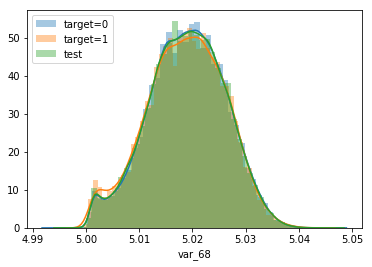

In [37]:
plot('var_68')

In [38]:
train_68 = train['var_68'] - 5
test_68 = test['var_68'] - 5

In [43]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [42]:
train['var_1'] - train_68

0         -6.7972
1         -4.1693
2         -2.7685
3         -2.1738
4         -1.5135
5         -2.3292
6         -0.1010
7         -8.0009
8          2.4269
9          1.9486
10        -0.5653
11        -8.0003
12        -4.6283
13         1.5669
14         5.0311
15         2.6477
16         0.2447
17        -1.8369
18         1.2566
19        -0.8138
20        -2.0482
21         1.4526
22         0.1632
23        -9.3800
24        -3.7494
25        -5.7129
26        -4.5129
27       -10.0130
28         4.5019
29        -2.6266
           ...   
199970    -2.5911
199971    -3.9359
199972    -2.6032
199973    -0.4649
199974    -5.8105
199975     1.0371
199976    -2.8611
199977    -0.8324
199978    -0.8999
199979    -2.9365
199980     6.2218
199981     0.6215
199982    -2.3743
199983     2.8036
199984     0.3581
199985    -3.6561
199986    -8.7996
199987    -1.9360
199988    -8.3769
199989    -4.5568
199990     1.8401
199991     2.5265
199992     2.6735
199993    -5.8277
199994    

In [5]:
kl = []
train_0 = train.query('target == 0')
train_1 = train.query('target == 1')
for c in train.columns[2:]:
    param_0 = norm.fit(train_0[c])
    param_1 = norm.fit(train_1[c])
    kl.append([c, entropy(param_0, param_1)])

kl = pd.DataFrame(kl, columns=['column', 'entropy'])

In [6]:
kl.describe()

,entropy
count,2.000000e+02
mean,inf
std,NaN
min,5.320802e-08
25%,1.995976e-05
50%,2.383566e-04
75%,8.473287e-03
max,inf


In [7]:
kl.sort_values('entropy')

,column,entropy
29,var_29,5.320802e-08
103,var_103,5.631154e-08
96,var_96,9.907548e-08
161,var_161,4.044650e-07
68,var_68,4.647036e-07
7,var_7,6.953198e-07
124,var_124,9.362053e-07
37,var_37,1.081624e-06
151,var_151,1.128935e-06
38,var_38,1.265450e-06


In [8]:
selected_kl = kl.query('entropy < 1.995976e-05').reset_index()['column'].values

# feature engineering

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.describe()

In [36]:
def plot(c):
    sns.distplot(train.query('target == 0')[c], label='target=0')
    sns.distplot(train.query('target == 1')[c], label='target=1') 
    sns.distplot(test[c], label='test') 
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
def log_plot(c):
    sns.distplot(np.log1p(train.query('target == 0')[c]), label='log,target=0')
    sns.distplot(np.log1p(train.query('target == 1')[c]), label='log,target=1')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
plot('var_53')

In [ ]:
log_plot('var_53')

In [ ]:
plot('var_174')

In [ ]:
plot('var_34')

In [ ]:
plot('var_6')

In [ ]:
plot('var_22')

In [ ]:
plot('var_76')

In [ ]:
train.query('target == 0').head(20)

In [ ]:
train.query('target == 1').head(20)

In [ ]:
df = pd.concat([train, test], axis=0)

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
for c in df.columns[2:]:
    df[c] = df[c] / (df[c].max() - df[c].min())

In [ ]:
df.head()

In [ ]:
train = df[df['target'].notnull()]

In [ ]:
train.tail()

# preprocess

In [9]:
y = train['target']

not_use_cols = ['ID_code', 'target'] 
# not_use_cols += list(selected_kl)
use_cols = [c for c in train.columns if c not in not_use_cols]

X = train[use_cols]
X_test = test[use_cols]

In [10]:
len(use_cols)

200

# Model 

## settings

In [16]:
SEED = 6

NFOLDS = 5

## params

In [17]:
params_in_train = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 200,
    'verbose_eval': 500,
}

In [18]:
params = {
    'boosting': 'gbdt',
    'metric': 'auc',
    'objective': 'binary',
    'max_depth': -1,
    'num_leaves': 9,
    'min_data_in_leaf': 32,
    'bagging_freq': 5,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'sub_sample': 0.6,
    'reg_alpha': 2,
    'reg_lambda': 5,
    'min_gain_to_split': 0.01,
    'min_child_wight': 19,
    'num_threads': cpu_count(),
    'verbose': -1,
    'seed': SEED, # int(2**fold_n),
    'bagging_seed': SEED, # int(2**fold_n),
    'drop_seed': SEED, # int(2**fold_n),
}

## cv

In [26]:
# kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# oof = np.zeros(len(X))
# predictions = np.zeros(len(X_test))

# for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):
#     print('fold: {}/{}'.format(fold+1, kf.n_splits))
    
#     model = LogisticRegression(random_state=0, n_jobs=-1).fit(X.iloc[train_index], y.iloc[train_index])
#     oof[valid_index] = model.predict(X.iloc[valid_index])
    
#     predictions += model.predict_proba(X_test)[:, 1] / NFOLDS
    

# cv_score = roc_auc_score(y, oof)**0.5
# print('Num folds: {}'.format(NFOLDS))
# print('CV Score: {:<8.5f}'.format(cv_score))

fold: 1/5
fold: 2/5
fold: 3/5
fold: 4/5
fold: 5/5
Num folds: 5
CV Score: 0.79239 


In [ ]:
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

oof = np.zeros(len(X))
predictions = np.zeros(len(X_test))
scores = {'train': [], 'valid': []}
features = X.columns
feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print('fold: {}/{}'.format(fold+1, kf.n_splits))
    
    dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
    dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])
    
    model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], **params_in_train)
    scores['train'].append(model.best_score['training']['auc'])
    scores['valid'].append(model.best_score['valid_1']['auc'])
    oof[valid_index] = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

    fold_feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])
    fold_feature_importance_df['feature'] = features
    fold_feature_importance_df['importance'] = model.feature_importance()
    fold_feature_importance_df['fold'] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance_df], axis=0)

    predictions += model.predict(X_test, num_iteration=model.best_iteration) / NFOLDS

cv_score = roc_auc_score(y, oof)**0.5
print('Num folds: {}'.format(NFOLDS))
print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
print('CV Score: {:<8.5f}'.format(cv_score))

In [ ]:
feature_importance_df.head()

In [ ]:
feature_importance_df['importance'] = feature_importance_df['importance'].astype('int')
mean = feature_importance_df['importance'].mean()
std = feature_importance_df['importance'].std()
width = 24
ordered_feature = feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 48))
sns.barplot(x='importance', y='feature', data=feature_importance_df, order=ordered_feature)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.vlines(mean, -width, width, colors='red')
# plt.vlines(mean+std, -width, width, colors='red', linestyles=':')
plt.show()

In [ ]:
sns.distplot(predictions)
plt.show()

# submission

In [ ]:
submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [ ]:
submission['target'] = predictions

In [ ]:
submission.to_csv('../submission/lightgbm.csv', index=False)

In [ ]:
# #!/usr/bin/env ptargetthon3
# # -*- coding: utf-8 -*-
# """
# Created on Mon Mar 4 2019

# @author: toshiki.ishikawa
# """
# import warnings
# warnings.simplefilter('ignore')

# import os
# import gc 
# import sys
# import datetime

# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import xgboost as xgb

# from tqdm import tqdm
# from collections import defaultdict
# from multiprocessing import cpu_count

# from sklearn.model_selection import StratifiedKFold, KFold 
# from sklearn.metrics import roc_auc_score

# #==============================================================================

# PATH = os.path.join('..', 'data')

# KEY = 'ID_code'

# SEED = 6
# # SEED = np.random.randint(9999)

# NTHREAD = cpu_count()

# NFOLDS = 2

# # =============================================================================
# # READ DATA
# # =============================================================================
# train = pd.read_csv(os.path.join(PATH, 'train.csv'))
# test = pd.read_csv(os.path.join(PATH, 'test.csv'))

# # =============================================================================
# # ADD HANDCRAFTED FEATURES
# # =============================================================================

# # =============================================================================
# # PREPROCESS
# # =============================================================================
# y = train['target']

# not_use_cols = ['ID_code', 'target'] 
# use_cols = [c for c in train.columns if c not in not_use_cols]

# X = train[use_cols]
# X_test = test[use_cols]

# # =============================================================================
# # PARAMS
# # =============================================================================
# params_in_train = {
#     'num_boost_round': 10000,
#     'early_stopping_rounds': 200,
#     'verbose_eval': 500,
# }

params = {
    'boosting': 'gbdt',
    'metric': 'auc',
    'objective': 'binary:logistic',
    'max_depth': 7,
    'num_leaves': 9,
    'min_data_in_leaf': 32,
    'bagging_freq': 5,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'sub_sample': 0.6,
    'reg_alpha': 2,
    'reg_lambda': 5,
    'min_gain_to_split': 0.01,
    'min_child_wight': 19,
    'num_threads': cpu_count(),
    'verbose': -1,
    'seed': SEED, # int(2**fold_n),
    'bagging_seed': SEED, # int(2**fold_n),
    'drop_seed': SEED, # int(2**fold_n),
}

# # =============================================================================
# # CV
# # =============================================================================
# skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# oof = np.zeros(len(X))
# predictions = np.zeros(len(X_test))
scores = []
# features = X.columns
# feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print('fold: {}/{}'.format(fold+1, skf.n_splits))
    
    dtrain = xgb.DMatrix(data=X.iloc[train_index], label=y.iloc[train_index])
    dvalid = xgb.DMatrix(data=X.iloc[valid_index], label=y.iloc[valid_index])
    
    model = xgb.train(params, dtrain, evals=[(dtrain, 'train'), (dvalid, 'valid')], **params_in_train)
    oof[valid_index] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)

    predictions += model.predict(xgb.DMatrix(data=X_test), ntree_limit=model.best_ntree_limit) / NFOLDS
    
    break
    
    del model

cv_score = roc_auc_score(y, oof)**0.5
print('Shape: {}'.format(X.shape))
print('Num folds: {}'.format(NFOLDS))
print('Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores), np.max(scores), np.min(scores), np.std(scores)))
print('CV Score: {:<8.5f}'.format(cv_score))

# cv_score = roc_auc_score(y, oof)**0.5
# print('Shape: {}'.format(X.shape))
# print('Num folds: {}'.format(NFOLDS))
# print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
#     np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
# print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
#     np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
# print('CV Score: {:<8.5f}'.format(cv_score))

In [ ]:
model.attributes()

In [ ]:
model.get_score()

In [ ]:
scores.append(roc_auc_score(y.iloc[valid_index], oof[valid_index])**0.5)

In [ ]:
scores